In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import IPython
import IPython.display

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data
raw_data = pd.read_csv('delanteros.csv', sep=';',encoding='latin-1')
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Tiros'])
raw_data = raw_data.dropna(subset = ['Tiros a puerta'])

# filtering out the last 2 columns
raw_data = raw_data[['Nombre','Fecha','Jornadas','Titular','Minutos','Goles','Asistencias','Tiros','Tiros a puerta']]

forecast_data = raw_data

forecast_data = forecast_data[~forecast_data['Nombre'].isin(['Lucas Boyé', 'Luis Javier Suárez', 'Alexander Isak', 'Rafa Mir'])]

# Limiting the columns we need
forecast_data = forecast_data[['Nombre','Jornadas','Goles']]

#Original Data
original = forecast_data[forecast_data['Nombre'] == 'Karim Benzema']
original1 = original[['Jornadas', 'Goles']]

####################################################################
original2 = forecast_data[forecast_data['Nombre'] == 'Luis Suárez']
original_2 = original2[['Jornadas', 'Goles']]
####################################################################
original3 = forecast_data[forecast_data['Nombre'] == 'Joselu']
original_3 = original3[['Jornadas', 'Goles']]
####################################################################
original4 = forecast_data[forecast_data['Nombre'] == 'Iñaki Williams']
original_4 = original4[['Jornadas', 'Goles']]
####################################################################
original5 = forecast_data[forecast_data['Nombre'] == 'Memphis Depay']
original_5 = original5[['Jornadas', 'Goles']]
####################################################################
original6 = forecast_data[forecast_data['Nombre'] == 'Juanmi']
original_6 = original6[['Jornadas', 'Goles']]
####################################################################
original7 = forecast_data[forecast_data['Nombre'] == 'Iago Aspas']
original_7 = original7[['Jornadas', 'Goles']]
####################################################################
original8 = forecast_data[forecast_data['Nombre'] == 'Santi Mina']
original_8 = original8[['Jornadas', 'Goles']]

In [3]:
# set the Jornada into index
original1.set_index('Jornadas', inplace=True)
original1

,Goles
Jornadas,
1,0
2,2
3,2
4,0
5,0
...,...
114,0
115,1
116,0


In [4]:
# set the Jornada into index
original_2.set_index('Jornadas', inplace=True)
original_2

,Goles
Jornadas,
1,0
2,0
3,2
4,1
5,0
...,...
101,1
102,2
103,0


In [5]:
# set the Jornada into index
original_3.set_index('Jornadas', inplace=True)
# set the Jornada into index
original_4.set_index('Jornadas', inplace=True)
# set the Jornada into index
original_5.set_index('Jornadas', inplace=True)
# set the Jornada into index
original_6.set_index('Jornadas', inplace=True)
# set the Jornada into index
original_7.set_index('Jornadas', inplace=True)
# set the Jornada into index
original_8.set_index('Jornadas', inplace=True)

In [6]:
original1_df1 = original1.diff(periods=1)
original1_df1.dropna(inplace=True)
####################################################################
original2_df2 = original_2.diff(periods=1)
original2_df2.dropna(inplace=True)
####################################################################
original3_df3 = original_3.diff(periods=1)
original3_df3.dropna(inplace=True)
####################################################################
original4_df4 = original_4.diff(periods=1)
original4_df4.dropna(inplace=True)
####################################################################
original5_df5 = original_5.diff(periods=1)
original5_df5.dropna(inplace=True)
####################################################################
original6_df6 = original_6.diff(periods=1)
original6_df6.dropna(inplace=True)
####################################################################
original7_df7 = original_7.diff(periods=1)
original7_df7.dropna(inplace=True)
####################################################################
original8_df8 = original_8.diff(periods=1)
original8_df8.dropna(inplace=True)

In [7]:
train_df_def = pd.concat([original1_df1,original2_df2,original3_df3,original4_df4,original5_df5,original6_df6,original7_df7,original8_df8])
train_df_def

,Goles
Jornadas,
2,2.0
3,0.0
4,-2.0
5,0.0
6,0.0
...,...
138,0.0
139,0.0
140,2.0


In [8]:
column_indices = {name: i for i, name in enumerate(train_df_def.columns)}

n = len(train_df_def)
train_df = train_df_def[0:int(n*0.7)]
val_df = train_df_def[int(n*0.7):int(n*0.9)]
test_df = train_df_def[int(n*0.9):]

num_features = train_df_def.shape[1]
print(num_features)
####################################################################

1


In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_def,val_df=val_df,test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df_def
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [11]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Goles'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Goles']

In [15]:
example_window = tf.stack([np.array(train_df_def[:w1.total_window_size]),
                           np.array(train_df_def[8:8+w1.total_window_size]),
                           np.array(train_df_def[15:15+w1.total_window_size]),
                           np.array(train_df_def[:w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')
example_inputs

All shapes are: (batch, time, features)
Window shape: (4, 7, 1)
Inputs shape: (4, 6, 1)
Labels shape: (4, 1, 1)


<tf.Tensor: shape=(4, 6, 1), dtype=float64, numpy=
array([[[ 2.],
        [ 0.],
        [-2.],
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 1.],
        [-1.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [-1.],
        [ 0.],
        [ 0.],
        [ 2.],
        [-1.]],

       [[ 2.],
        [ 0.],
        [-2.],
        [ 0.],
        [ 0.],
        [ 0.]]])>

In [16]:
def plot(self, model=None, plot_col='Goles', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normalizado]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Jornada')

WindowGenerator.plot = plot

In [17]:
w1.example = example_inputs, example_labels

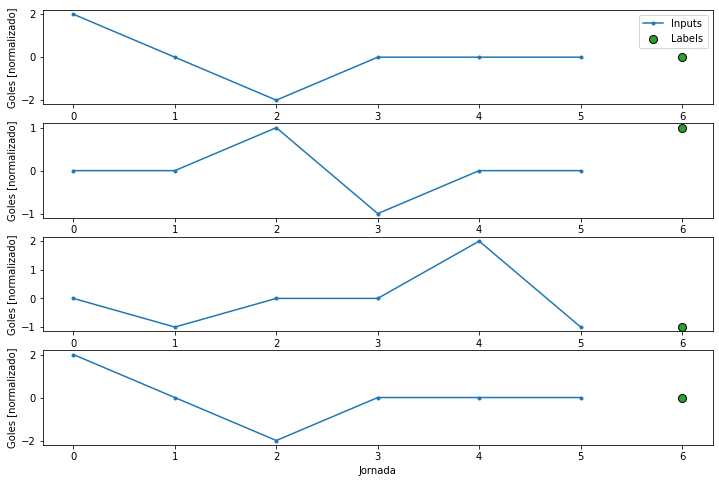

In [18]:
w1.plot()

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [22]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [23]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Goles'])

conv_window.make_dataset

<bound method make_dataset of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Goles']>

In [24]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance={}
performance={}
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

6/6 [==============================] - 0s 1ms/step - loss: 0.4481 - mean_absolute_error: 0.5371


In [25]:
LABEL_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Goles'])

wide_conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [3 4 5]
Label column name(s): ['Goles']

In [26]:
print("Wide window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide window
Input shape: (32, 5, 1)
Labels shape: (32, 3, 1)
Output shape: (32, 3, 1)


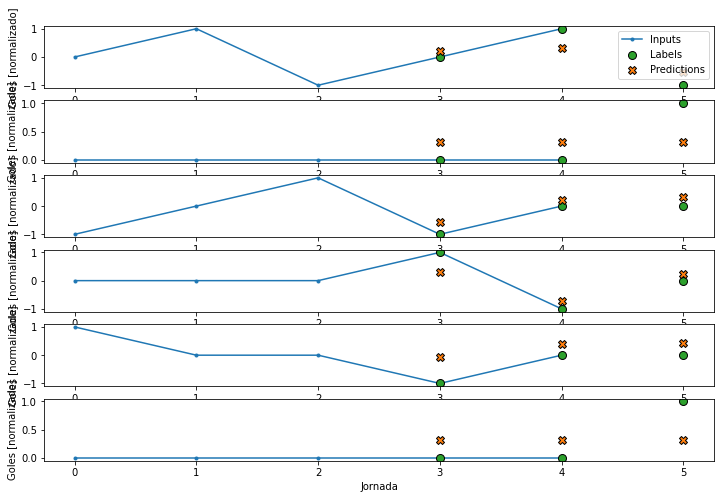

In [27]:
wide_conv_window.plot(conv_model)

## Multiples pasos

In [101]:
OUT_STEPS = 4
multi_window = WindowGenerator(input_width=4,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['Goles'])



6/6 [==============================] - 0s 4ms/step - loss: 1.7456 - mean_absolute_error: 0.9474


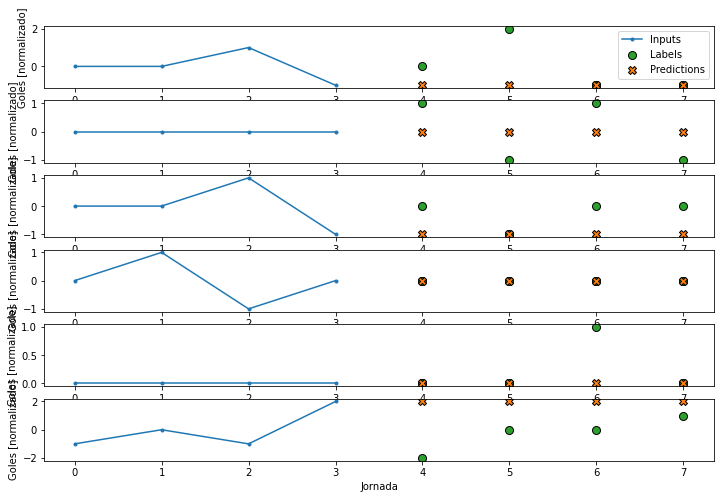

In [102]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
history=last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

6/6 [==============================] - 0s 999us/step - loss: 1.4225 - mean_absolute_error: 0.8611


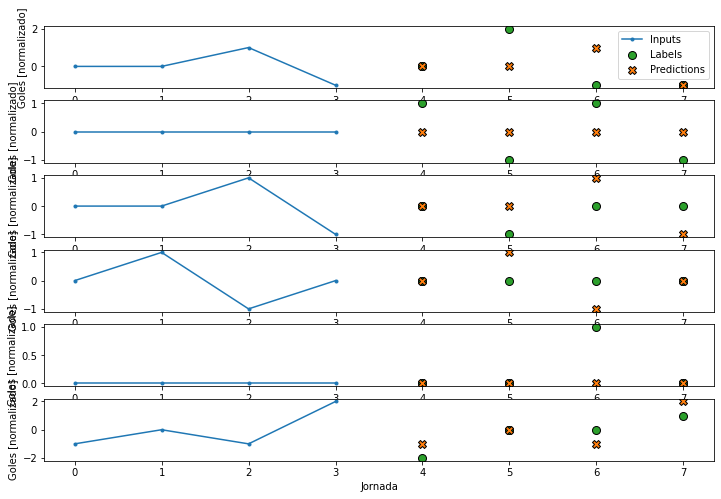

In [103]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

6/6 [==============================] - 0s 3ms/step - loss: 0.7475 - mean_absolute_error: 0.5718


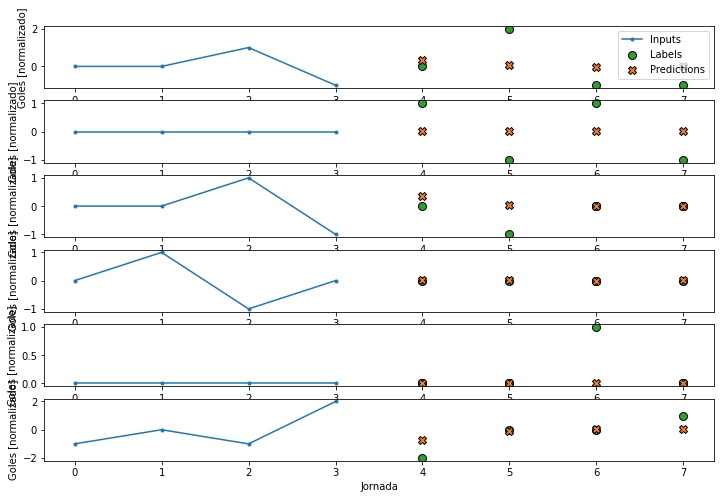

In [104]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [105]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)


IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)


6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - mean_absolute_error: 0.5725


6/6 [==============================] - 0s 1ms/step - loss: 0.7032 - mean_absolute_error: 0.5700


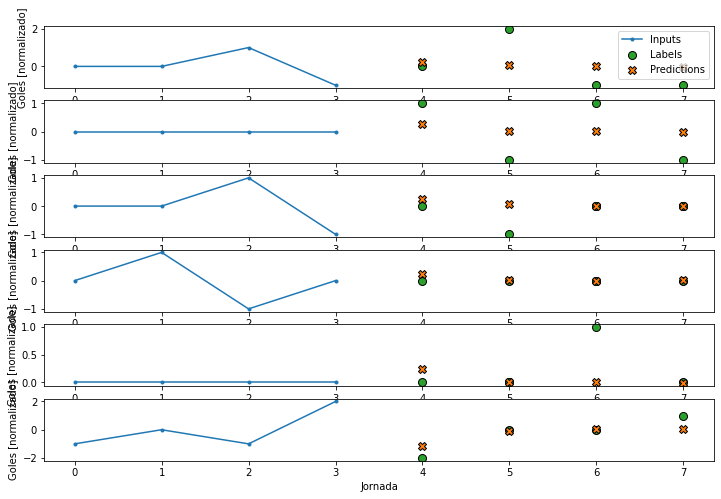

In [106]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - mean_absolute_error: 0.5706


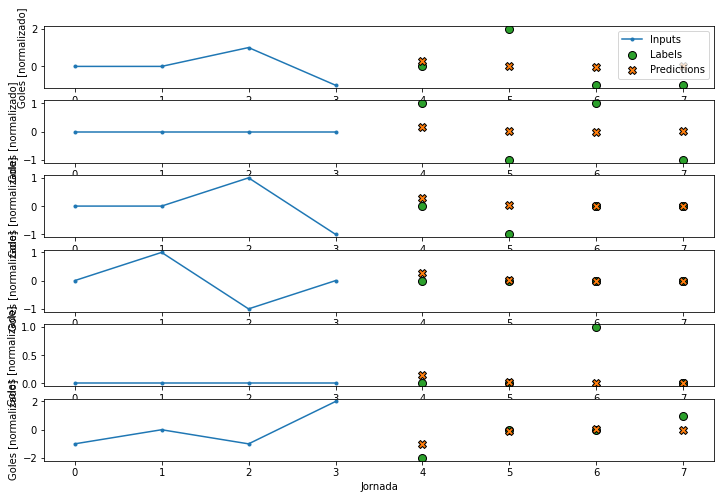

In [107]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [108]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [109]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [110]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [111]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [112]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

6/6 [==============================] - 0s 4ms/step - loss: 0.7090 - mean_absolute_error: 0.5715


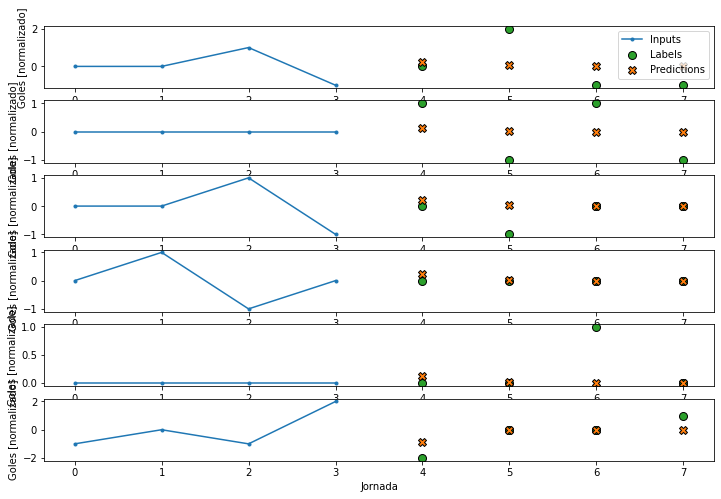

In [113]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [114]:
for name, value in multi_performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.8354
Repeat      : 0.8079
Linear      : 0.4755
Dense       : 0.4844
Conv        : 0.4837
LSTM        : 0.4782
AR LSTM     : 0.4764
